In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)
import pickle
import sys, os
import time
import libcamodocal
import matplotlib.pyplot as plt
import cv2
import quaternion
from IPython import display
from IPython.display import clear_output
import glob
import calib_utils
import calib
import geo_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# define cb pattern
cb_pattern = (5,6)

#define checkerboard pattern size [m]
cb_size = .04
# generate pattern_3d
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

# load calib data
calib_data = pickle.load( open("/home/ralfi/Desktop/calibdata_29_04_2022_23_31_04_numData_45.pkl", "rb" ))

ir_lfs = calib_data['ir_lf']
ir_rgs = calib_data['ir_rg']
rgbs = calib_data['color_gray']
poses_urx = calib_data['poses_urx']
    
# Setup Camera intrinsics
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001)

## HARDCODED CAM APRAMS 
dist = np.array([0.151528, 0.467126, -0.000977263, -0.00148684, 0.409874])
K = np.array([[1363.44, 0, 967.833], [0, 1363.09, 534.441], [0, 0, 1]])

print(K)
print(dist)

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

[[1363.44     0.     967.833]
 [   0.    1363.09   534.441]
 [   0.       0.       1.   ]]
[ 0.151528    0.467126   -0.00097726 -0.00148684  0.409874  ]


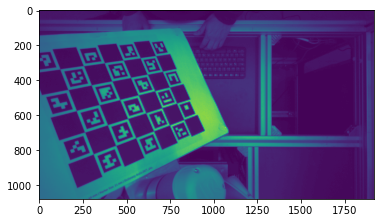

In [10]:
plt.imshow(ir_rgs[0][0])

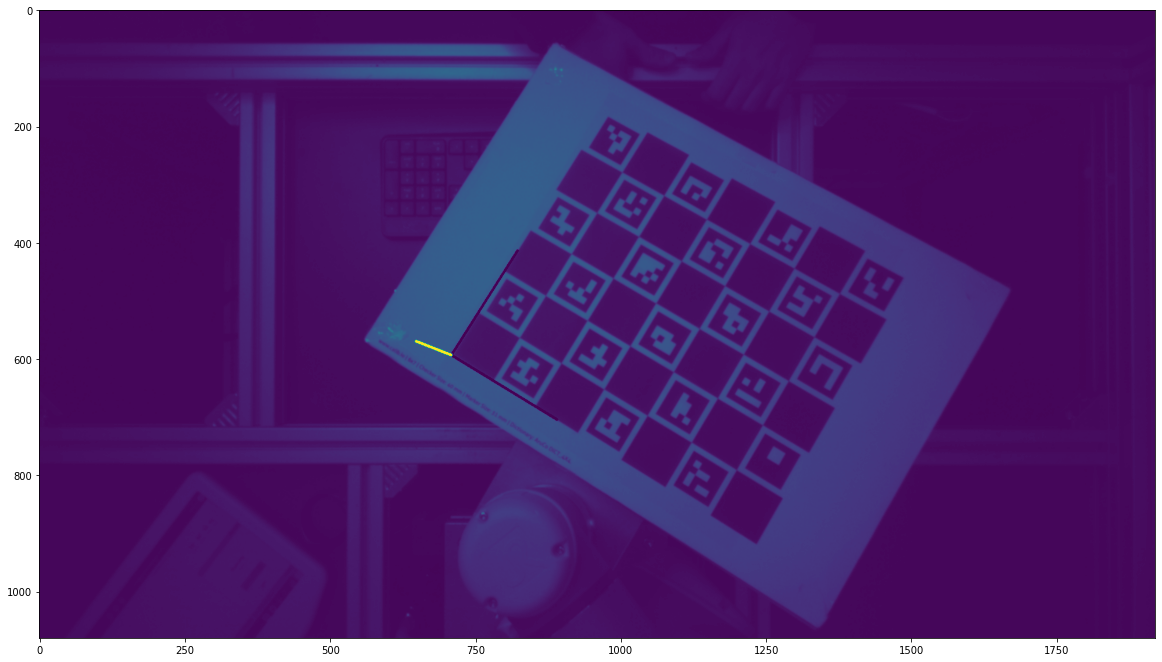

In [ ]:
N = len(rgbs)

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

# Setup Marker
marker_type = 'charuco'
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard_create(7, 6, 0.04, 0.031, aruco_dict)

# lists for graph hand eye
list_points_2d, obj_poses, obj_poses_inv, hand_poses, hand_poses_inv = [], [], [], [], []

for i in range(N):
    
    frames = np.array(ir_rgs[i])
    #frames = np.array(rgbs[i][0])
    #calculate cam_pose
    
    p_tvec_median, p_rvec_median, homTF_obj, corners_median, c_corner_median, points_2d_median, imgs = calib_utils.estimate_cam_pose_charuco(frames, K, dist, board, aruco_dict, debug = False)
    #p_tvec_median, p_rvec_median, homTF_obj, corner_img_all, corner_img_all = calib_utils.estimate_cam_pose_checker(frames, K, dist, cb_pattern, pattern_3d, dist, criteria, debug = True)
    if(len(p_tvec_median)==0 and len(p_rvec_median)==0):
        continue
        
    #review and skip 
    if (not calib_utils.review_img(imgs[0])):
        continue
        
    
    #calculate hand psoe
    pose_homTF = geo_utils.pose7d2homTF(geo_utils.urx_trans_to_pose(poses_urx[i][0]))
    pose_homTF_inv = np.linalg.inv(pose_homTF)
    homTF_obj_inv = np.linalg.inv(homTF_obj)
        
    #list_points_2d
    #if(len(c_corner_median) == 30):
    if True:
        obj_poses.append(homTF_obj)
        obj_poses_inv.append(homTF_obj_inv)
        hand_poses.append(pose_homTF)
        hand_poses_inv.append(pose_homTF_inv)
    
        cgi_cal.add_sample(pose_homTF_inv, homTF_obj)

In [5]:
dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print("dani\n", dani)

tsai = cgi_cal.solve(calib.solver.TsaiLenz1989)
print("tsai\n", tsai)

park = cgi_cal.solve(calib.solver.ParkBryan1994)
print("park\n", park)

dani
 [[ 0.00026211 -0.99989611 -0.01441151  0.41974368]
 [-0.9998672  -0.00049687  0.01628909 -0.02044741]
 [-0.01629456  0.01440533 -0.99976346  0.89931583]
 [ 0.          0.          0.          1.        ]]
tsai
 [[ 0.40349913 -0.85652545  0.32179591  0.39077321]
 [-0.78593882 -0.14437135  0.60121301 -0.10704381]
 [-0.46849613 -0.49550082 -0.73143032  0.86087883]
 [ 0.          0.          0.          1.        ]]
park
 [[ 0.01102065 -0.99950735 -0.02938728  0.39656505]
 [-0.99909121 -0.01221668  0.04083503 -0.07383242]
 [-0.04117393  0.02891055 -0.99873364  0.92048727]
 [ 0.          0.          0.          1.        ]]


In [8]:
print("dani\n", geo_utils.homTF2pose7d(dani))

print("tsai\n", geo_utils.homTF2pose7d(tsai))

print("park\n", geo_utils.homTF2pose7d(park))


dani
 [ 0.39615645 -0.09410621  1.00500693 -0.01088278 -0.75054869  0.66066986
  0.00857682]
tsai
 [ 0.42970073  0.16449018  0.62013084 -0.66178075 -0.63094912  0.3632259
 -0.17893124]
park
 [ 0.45245623 -0.09096307  0.82624001 -0.00854756 -0.73260685  0.67948346
  0.03894052]


In [6]:
lol = libcamodocal.py_camodocal_calibration(hand_poses_inv, obj_poses_inv, {}, False)
print(lol)

[[-0.28715052  0.63907859 -0.71352865  0.40292367]
 [ 0.94472849  0.31198617 -0.10076063 -0.13199509]
 [ 0.1582171  -0.70302431 -0.69334275  0.29076778]
 [ 0.          0.          0.          1.        ]]


In [7]:
np.linalg.inv(lol)

array([[-0.28715052,  0.94472849,  0.1582171 ,  0.19439483],
       [ 0.63907859,  0.31198617, -0.70302431, -0.01190243],
       [-0.71352865, -0.10076063, -0.69334275,  0.4757994 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [22]:
# generate pattern_3d
cb_pattern = (5, 6)
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

In [11]:
# setup pars
params={}
params['pattern2d_inf_scale'] = 1e-6
params['world2hand_inf_scale_trans'] = 1e-6
params['world2hand_inf_scale_rot'] = 1
params['num_iterations'] = 1000*8192
params['solver_name'] = "lm_var_cholmod"
params['robust_kernel_handpose'] = "Huber"
params['robust_kernel_projection'] = "Huber"
params['robust_kernel_handpose_delta'] = 1e-6
params['robust_kernel_projection_delta'] = 1e-6

init_object2world = np.eye(4)

init_hand2eye = park

#hand2eye_visp, object2world_visp = cb.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm, list_points_2d, init_hand2eye, init_object2world, True, params)

hand2eye_graph, object2world_graph = calib.py_spatial_calibration_graph(K, pattern_3d, hand_poses_inv, list_points_2d, init_hand2eye, init_object2world, True, params)


print('init park:')
print(park)
print('hand2eye_graph:')
print(hand2eye_graph)
print('hand2eye_graph inv:')
print(np.linalg.inv(hand2eye_graph))
#print('object2world_graph:')
#print(object2world_graph)

#diff = abs(np.linalg.inv(hand2eye_graph) - calib_utils.pose7d2homTF(calib_data['ground_truth']))
#print('diff:')
#print(diff)

AttributeError: module 'calib' has no attribute 'py_spatial_calibration_graph'

In [8]:
pwd

'/home/ralfi/git/camodocal/nbs'

In [23]:
# MAIN
import camera_calib_utils

np.set_printoptions(suppress=True)
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard_create(7, 6, 0.04, 0.031, aruco_dict)

allCorners,allIds,imsize = camera_calib_utils.read_charuco_board(ir_lfs, board, aruco_dict, debug=False)
    
%time ret, mtx, dist, rvecs, tvecs = camera_calib_utils.calibrate_charuco_camera(allCorners, allIds, imsize, board)

print(mtx)
    

POSE ESTIMATION STARTS:
CAMERA CALIBRATION
CPU times: user 962 ms, sys: 0 ns, total: 962 ms
Wall time: 958 ms
[[1404.04471953    0.          938.7502304 ]
 [   0.         1404.04471953  534.61327982]
 [   0.            0.            1.        ]]


In [24]:
K

array([[1363.44 ,    0.   ,  967.833],
       [   0.   , 1363.09 ,  534.441],
       [   0.   ,    0.   ,    1.   ]])

In [8]:
len(obj_poses)

29